In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from yahoo_fin.stock_info import get_earnings_history
from fredapi import Fred
from dotenv import load_dotenv
import os
import pandas_datareader as web
import lightgbm as lgb
import shap
from datetime import datetime,timedelta
import pickle
import gbdt_module


In [122]:
#From yahoo
sp_500 = yf.download(tickers="^GSPC",start="1995-01-01",interval="1d")
#Download data from FRED API
load_dotenv() #Create environment variable
API_KEY = os.getenv("API_KEY") #Get API_KEY from .env file
fred = Fred(api_key = API_KEY)
###*****Don't change order of the series names*****###
series_fred = ['BAMLC0A0CM','BAMLH0A0HYM2','DCOILWTICO','DTB3','DGS5','DGS10','DGS30','T5YIE','T10YIE','T10Y2Y','T10Y3M','VIXCLS','DEXUSEU','DEXJPUS','DEXUSUK','DEXCHUS']
start_fred = '1/1/1995'
ticker_yf = '^GSPC'
start_yf = '1995-01-01'
interval='1d'
series_names = ['ig_spread','hy_spread','wti','treas_3m','treas_5y','treas_10y','treas_30y','binf_5y','binf_10y','y10_y2','y10_m3','vix','eur','jpy','gbp','cny']

fred_series,sp_data = download_data(fred,series_fred,start_fred,ticker_yf,start_yf,interval,series_names)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [123]:
""" Features:
1. S&P 500 returns variance - 5 day,10 day and 21 day
2. IG and HY spread
3. Change in IG and HY spread in bps
4. Change in crude oil prices
5. 3m,5y,10y and 30y yields
6. Change in 3m,5y,10y,30y in bps
7. 5y and 10y breakeven inflation
8. Change in 5y,10y breakeven in bps
9. 2s10s,3m10s
10. Change in 2s10s,3m10s
11. VIX and change in VIX
12. Change in currencies
"""
data_0,feature_num,sp_return5,sp_return10,sp_return15 = derive_features(fred_series,sp_data)


In [350]:
#Let's check their percentile distribution
#N E E D   A   P L O T


0.05   -0.063382
0.10   -0.042189
0.15   -0.030648
0.20   -0.020853
0.25   -0.013444
0.50    0.009856
0.90    0.046676
Name: Adj Close, dtype: float64

In [ ]:
########################################################## Light GBM ###############################################################################

In [126]:
#Create target series
percentile_list = [5,10,15,20,25]
y_5d = create_target_series(sp_return5,percentile_list,f_horizon=5)
y_10d = create_target_series(sp_return10,percentile_list,f_horizon=10)
y_15d = create_target_series(sp_return15,percentile_list,f_horizon=15)
#Reindex features data
data_5d = reindex_features_data(data_0,5,y_5d)
data_10d = reindex_features_data(data_0,10,y_10d)
data_15d = reindex_features_data(data_0,15,y_15d)
#Create feature list
f_names = ['sp_var5','sp_var10','sp_var21','ig_spread','ig_change','hy_spread','hy_change','wti_change','treas3m_change','treas5y_change','treas10y_change','treas30y_change','binf5_change','binf10_change','y10_y2','y10_m3','y10_m3change','y10_y2change','vix_change','eur_change','jpy_change','gbp_change','cny_change']
features_names = pd.DataFrame(f_names,feature_num)


In [ ]:
############################################################# 5 -day ahead model ########################################################################

In [127]:
#Train-test split
train_size,valid_size,test_size = data_split_size(data_5d,0.75)
x_train,y_train,x_valid,y_valid,x_test,y_test = data_split(data_5d,y_5d,train_size,valid_size,test_size)

[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.1918
[2]	training's binary_logloss: 0.186192
[3]	training's binary_logloss: 0.181424
[4]	training's binary_logloss: 0.17728
[5]	training's binary_logloss: 0.173994
[6]	training's binary_logloss: 0.17102
[7]	training's binary_logloss: 0.167877
[8]	training's binary_logloss: 0.165471
[9]	training's binary_logloss: 0.163308
[10]	training's binary_logloss: 0.161418
Training - The ROC AUC of model's prediction is: 0.8593627006765976
Validation - The ROC AUC of model's prediction is: 0.6411820699203876
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


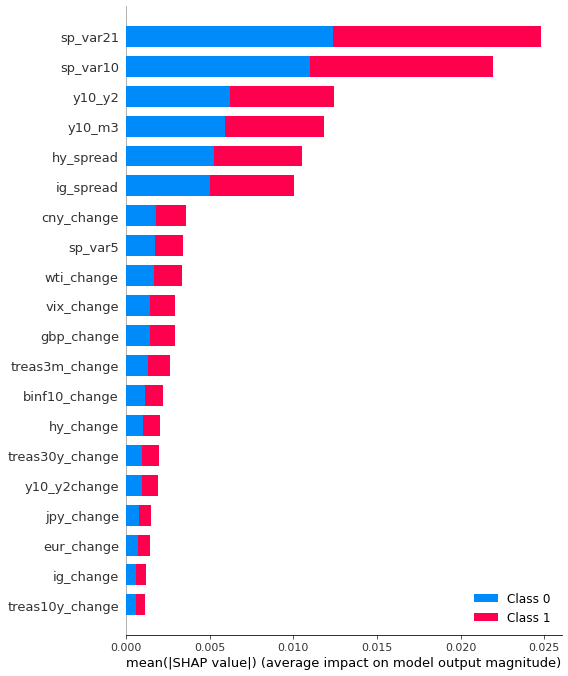

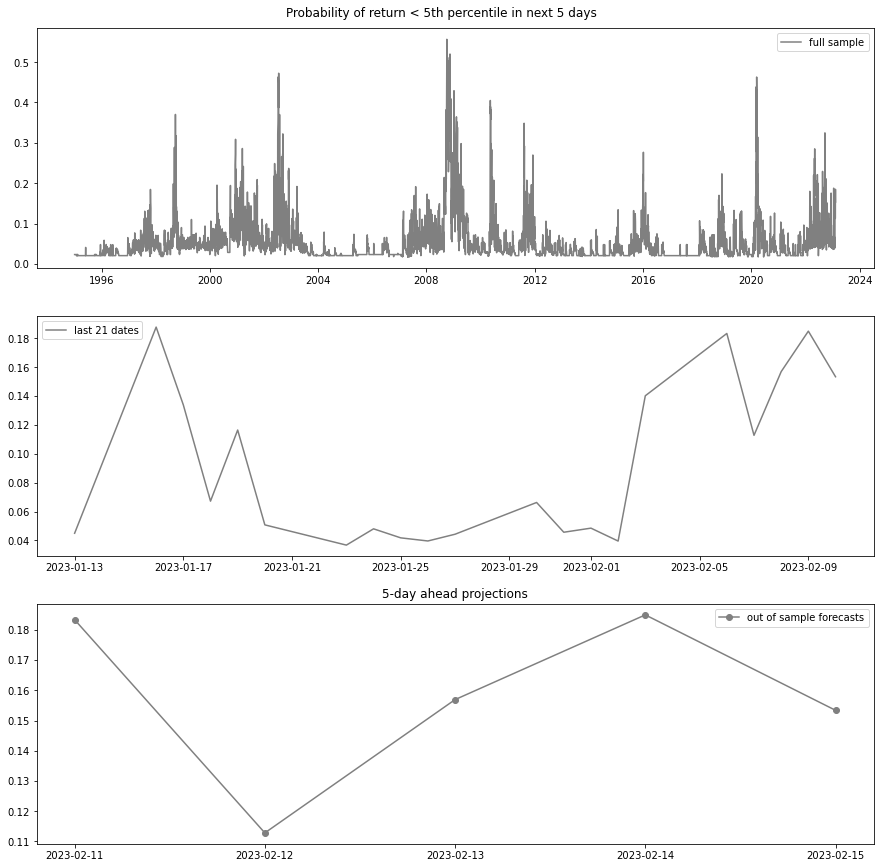

In [64]:
#config
params = {
    'bossting_type': 'gbdt',
    'ojective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves':20, 
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction':0.7,
    'bagging_freq':5,
    'verbose': 0
}
###### 5-day ahead model 1 ######

#create a dataset for lightgbm
lgb_train= lgb.Dataset(x_train,y_train['sp_binary1'],free_raw_data=False)
lgb_eval = lgb.Dataset(x_valid,y_valid['sp_binary1'],reference=lgb_train,free_raw_data=False)
y_train_target = y_train['sp_binary1']
y_valid_target = y_valid['sp_binary1']
y_test_target = y_test['sp_binary1']
#other lgbm inputs
valid_set = lgb_train
num_boost=10

######Start training first 10 rounds ######

gbm,y_pred_train,auc_train_model = train_first_rounds(params,lgb_train,num_boost,valid_set,feature_num,x_train,y_train_target)
gbm.save_model('model_5d1.txt')
saved_model = 'model_5d1.txt'

######Validate ######

bst,y_pred_valid,auc_loaded_model = validate(saved_model,x_valid,y_valid_target)

######Start training next 10 rounds with learning decay ######
prev_model = gbm
valid_set = lgb_eval
learning_param = 0.05
gbm,y_pred_train,auc_train_model = train_second_rounds(params,lgb_train,num_boost,prev_model,valid_set,feature_num,x_train,y_train_target,learning_param)
gbm.save_model('model_5d1_learning_decay.txt')
saved_model = 'model_5d1_learning_decay.txt'

######Validate ######

bst,y_pred_valid,auc_loaded_model = validate(saved_model,x_valid,y_valid_target)

######Start training next 10 rounds with early stopping ######
prev_model = gbm
stopping_rounds = 5
gbm,y_pred_train,auc_train_model = train_third_rounds(params,lgb_train,num_boost,prev_model,valid_set,feature_num,stopping_rounds,x_train,y_train_target)
gbm.save_model('model_5d1_early_stopping.txt')
saved_model = 'model_5d1_early_stopping.txt'

######Validate ######
bst,y_pred_valid,auc_loaded_model = validate(saved_model,x_valid,y_valid_target)

######Test ########
bst,y_pred_test,auc_test_model = test_final_model(saved_model,x_test,y_test_target)

######Full sample model run ######
lgb_train = lgb.Dataset(data_5d,y_5d['sp_binary1'],free_raw_data=False)
valid_set = lgb_train
data_full_sample = data_5d
y_full_sample = y_5d['sp_binary1']

gbm = full_sample_model(params,lgb_train,num_boost,valid_set,feature_num,stopping_rounds,data_full_sample,y_full_sample,learning_param)
gbm.save_model('model_5d1_full_sample.txt')
saved_model = 'model_5d1_full_sample.txt'

full_sample_preds,auc_full_model =  full_sample_predict(saved_model,data_full_sample,y_full_sample)

#######Pickle 5day ahead model#######

with open('5day_ahead.pkl','wb') as fout:
    pickle.dump(gbm,fout)


######Sample including the last 5 days#######
with open('5day_ahead.pkl','rb') as fin:
    pkl_5day = pickle.load(fin)

y_pred_5day = pkl_5day.predict(data_0)

######Feature importance######
#print(f"Fetaure importances: {list(gbm.feature_importance())}")
#SHAP values
plot_shap(gbm,data_0,f_names)

######plot model predictions#####
percentile=5
plot_predictions(f_horizon,y_pred_5day,5,data_0)
